# Fraud Detection Walkthrough

This notebook walks through the same stages covered by the project scripts: loading the raw transactions, engineering features, running a few quick EDA visuals, building the preprocessing pipeline, and training/evaluating candidate models.

## Setup

- Import the reusable utilities from the codebase.
- Ensure artifact folders exist.
- Configure plotting defaults.

In [1]:
import json
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

from config import (
    ensure_directories,
    DATA_PATH,
    ARTIFACTS_DIR,
    EDA_DIR,
    MODEL_DIR,
    SAVED_MODEL_PATH,
    METRICS_PATH,
)
from data_pipeline import engineer_features, train_test_split_features, build_preprocessor
from train_models import _model_spaces, _create_search, _evaluate

ensure_directories()
sns.set_theme(style="whitegrid", context="notebook")
ARTIFACTS_DIR, EDA_DIR, MODEL_DIR

(PosixPath('/content/artifacts'),
 PosixPath('/content/artifacts/eda'),
 PosixPath('/content/artifacts/models'))

## Load the raw dataset

The project ships with `transactions.csv`. We start by inspecting its shape, column types, and basic class balance.

In [2]:
raw = pd.read_csv(DATA_PATH)
print(f"Rows: {len(raw):,} | Columns: {raw.shape[1]}")
raw.dtypes

Rows: 299,695 | Columns: 17


,0
transaction_id,int64
user_id,int64
account_age_days,int64
total_transactions_user,int64
avg_amount_user,float64
amount,float64
country,object
bin_country,object
channel,object
merchant_category,object


In [3]:
display(raw.head())

class_balance = (
    raw["is_fraud"].value_counts().rename_axis("is_fraud").reset_index(name="count")
)
class_balance["fraction"] = class_balance["count"] / len(raw)
class_balance

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0


,is_fraud,count,fraction
0,0,293083,0.977938
1,1,6612,0.022062


## Feature engineering

Use the reusable helper from `data_pipeline.py` to add time-based, ratio, and geographic flags. This mirrors what the training and serving code expects.

In [4]:
engineered = engineer_features(raw)
print(f"Columns after engineering: {len(engineered.columns)}")
display(engineered.head())
engineered.dtypes

Columns after engineering: 22


,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,...,three_ds_flag,shipping_distance_km,is_fraud,transaction_hour,transaction_day,transaction_month,is_weekend,country_mismatch,amount_vs_avg,days_since_first
0,1,141,47,147.93,84.75,FR,FR,web,travel,0,...,1,370.95,0,4,5,1,1,0,0.572906,0.000000
1,1,141,47,147.93,107.90,FR,FR,web,travel,0,...,0,149.62,0,20,1,1,0,0,0.729399,3.669537
2,1,141,47,147.93,92.36,FR,FR,app,travel,1,...,1,164.08,0,6,4,1,0,0,0.624349,6.090648
3,1,141,47,147.93,112.47,FR,FR,web,fashion,0,...,1,397.40,0,17,0,1,0,0,0.760292,9.535012
4,1,141,47,147.93,132.91,FR,US,web,electronics,0,...,1,935.28,0,1,2,1,0,1,0.898465,10.887407


,0
user_id,int64
account_age_days,int64
total_transactions_user,int64
avg_amount_user,float64
amount,float64
country,object
bin_country,object
channel,object
merchant_category,object
promo_used,int64


In [5]:
# Quick summary statistics (numeric only to keep output readable)
engineered.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,299695.0,3002.559432,1732.309663,1.000000,1501.000000,3007.000000,4504.000000,6000.000000
account_age_days,299695.0,973.397871,525.241409,1.000000,516.000000,975.000000,1425.000000,1890.000000
total_transactions_user,299695.0,50.673321,5.976391,40.000000,46.000000,51.000000,56.000000,60.000000
avg_amount_user,299695.0,148.142973,200.364624,3.520000,46.190000,90.130000,173.450000,4565.290000
amount,299695.0,177.165279,306.926507,1.000000,42.100000,89.990000,191.110000,16994.740000
promo_used,299695.0,0.153640,0.360603,0.000000,0.000000,0.000000,0.000000,1.000000
avs_match,299695.0,0.837999,0.368453,0.000000,1.000000,1.000000,1.000000,1.000000
cvv_result,299695.0,0.872110,0.333968,0.000000,1.000000,1.000000,1.000000,1.000000
three_ds_flag,299695.0,0.784588,0.411109,0.000000,1.000000,1.000000,1.000000,1.000000
shipping_distance_km,299695.0,357.049028,427.672074,0.000000,136.600000,273.020000,409.180000,3748.560000


## Exploratory data analysis

Below are a few light-weight plots that echo what `eda.py` generates. Feel free to adapt for deeper analysis.

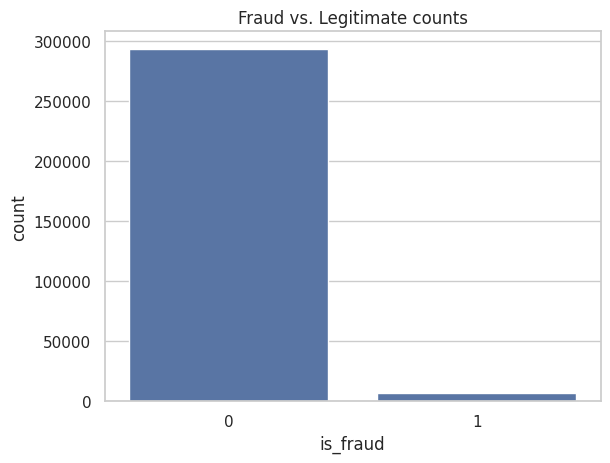

<Figure size 640x480 with 0 Axes>

In [6]:
# Target distribution
sns.countplot(data=engineered, x="is_fraud")
plt.title("Fraud vs. Legitimate counts")
plt.show()

# Save copy to artifacts/eda for consistency with scripts
EDA_DIR.mkdir(parents=True, exist_ok=True)
plt.gcf().savefig(EDA_DIR / "target_distribution.png", dpi=200)

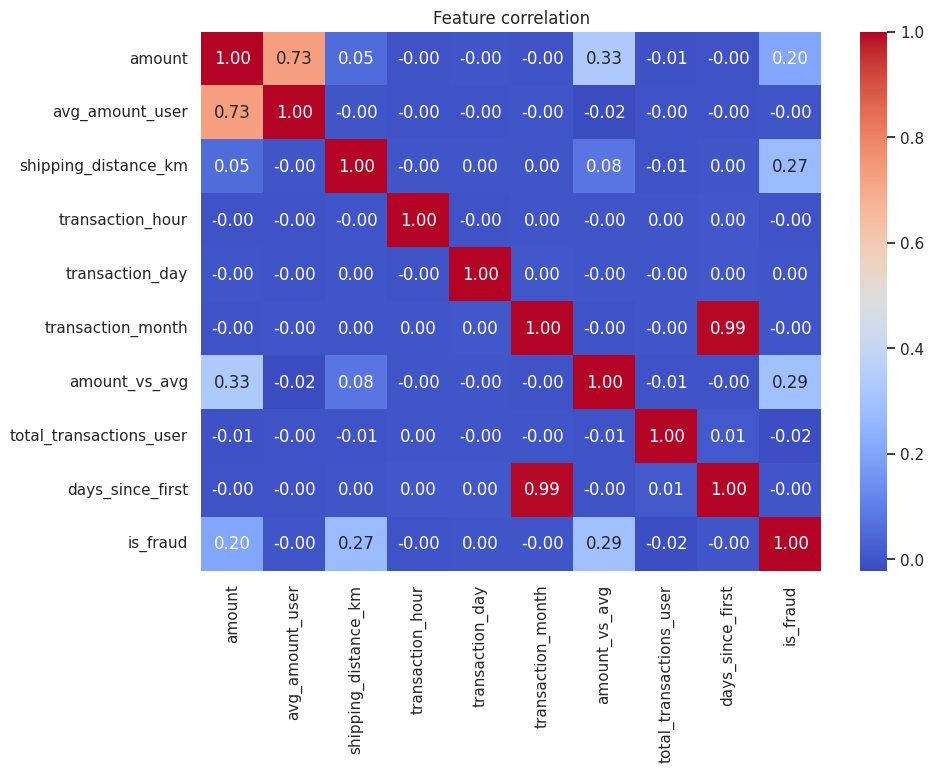

<Figure size 640x480 with 0 Axes>

In [7]:
# Correlation heatmap on a focused set of engineered numeric features
corr_cols = [
    "amount",
    "avg_amount_user",
    "shipping_distance_km",
    "transaction_hour",
    "transaction_day",
    "transaction_month",
    "amount_vs_avg",
    "total_transactions_user",
    "days_since_first",
    "is_fraud",
]

plt.figure(figsize=(10, 7))
sns.heatmap(engineered[corr_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature correlation")
plt.show()
plt.gcf().savefig(EDA_DIR / "correlation_heatmap_notebook.png", dpi=200)

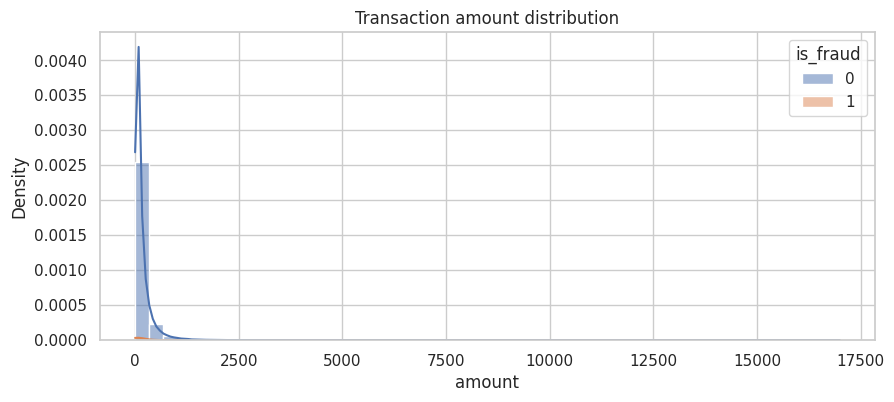

<Figure size 640x480 with 0 Axes>

In [8]:
# Distribution of amounts vs fraud flag
plt.figure(figsize=(10, 4))
sns.histplot(engineered, x="amount", hue="is_fraud", bins=50, stat="density", kde=True)
plt.title("Transaction amount distribution")
plt.show()
plt.gcf().savefig(EDA_DIR / "amount_distribution_notebook.png", dpi=200)

In [9]:
# Channel-level fraud rate snapshot
channel_stats = (
    engineered.groupby("channel")["is_fraud"].agg(["mean", "count"]).sort_values("mean", ascending=False)
)
channel_stats

,mean,count
channel,,
web,0.035644,152226
app,0.008042,147469


## Train/test split and preprocessing

Re-use the `ColumnTransformer` from `data_pipeline.py` to handle numeric scaling, binary flags, and one-hot encoding for categoricals.

In [10]:
dataset = train_test_split_features(engineered, test_size=0.3, random_state=42)
dataset.X_train.head()

,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,...,cvv_result,three_ds_flag,shipping_distance_km,transaction_hour,transaction_day,transaction_month,is_weekend,country_mismatch,amount_vs_avg,days_since_first
122731,2459,1557,48,148.37,68.75,NL,PL,app,gaming,0,...,1,1,1329.56,22,0,1,0,1,0.463369,0.000000
6868,138,1309,54,65.23,85.77,IT,IT,app,fashion,0,...,1,1,264.55,17,0,10,0,0,1.314886,295.932431
103315,2069,146,60,373.44,361.28,TR,IT,app,travel,0,...,1,1,1589.87,10,3,8,0,1,0.967438,218.055475
17995,362,461,58,416.86,260.96,GB,GB,app,fashion,0,...,1,1,386.56,23,0,9,0,0,0.626014,269.348472
171417,3437,1646,47,159.77,319.05,US,DE,web,grocery,0,...,1,1,1936.90,10,1,6,0,1,1.996933,134.730208


In [11]:
preprocessor = build_preprocessor()
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['account_age_days', 'total_transactions_user',
                                  'avg_amount_user', 'amount',
                                  'shipping_distance_km', 'transaction_hour',
                                  'transaction_day', 'transaction_month',
                                  'amount_vs_avg', 'days_since_first']),
                                ('binary',
                                 Pipeline(steps=[...ter',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['promo_used', 'avs_match', 'cvv_result',
                                  'three_ds_flag', 'is_weekend',
                                  'country_mismatch']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['country', 'bin_country', 'channel',
                                  'merchant_category'])])

In [12]:
# Fit the preprocessor once so we can inspect the transformed shape
preprocessor.fit(dataset.X_train, dataset.y_train)
sample_transformed = preprocessor.transform(dataset.X_train.head(3))
sample_transformed.shape

(3, 43)

## Model training and evaluation

This mirrors `train_models.py` but uses fewer iterations to keep the notebook snappy. The helper functions `_model_spaces`, `_create_search`, and `_evaluate` are imported from the project code.

In [ ]:
random_state = 42
best_estimator = None
best_metrics = None
best_model_name = None

for name, (estimator, search_space) in _model_spaces(random_state).items():
    print(f"Searching {name}...")
    search = _create_search(estimator, search_space, random_state=random_state, n_iter=5)
    search.fit(dataset.X_train, dataset.y_train)
    metrics = _evaluate(search.best_estimator_, dataset.X_test, dataset.y_test)
    print(f"{name} ROC-AUC: {metrics['roc_auc']:.4f} | PR-AUC: {metrics['pr_auc']:.4f}")

    if best_metrics is None or metrics["roc_auc"] > best_metrics["roc_auc"]:
        best_metrics = metrics
        best_estimator = search.best_estimator_
        best_model_name = name

print("\nBest model:", best_model_name)
best_metrics

Searching log_reg...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
log_reg ROC-AUC: 0.9424 | PR-AUC: 0.6315
Searching random_forest...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# Decompose metrics for quick review
print(json.dumps(best_metrics, indent=2))

## Save the champion pipeline and metrics (optional)

Persisting keeps the notebook aligned with the CLI + FastAPI service expectations. Skip this cell if you only want to explore.

In [ ]:
if best_estimator is not None and best_metrics is not None:
    MODEL_DIR.mkdir(parents=True, exist_ok=True)
    joblib.dump(best_estimator, SAVED_MODEL_PATH)
    METRICS_PATH.write_text(json.dumps({"model_name": best_model_name, **best_metrics}, indent=2))
    print(f"Saved {best_model_name} to {SAVED_MODEL_PATH}")
else:
    print("Train a model first to save artifacts.")